In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      # transforms.CenterCrop(26),
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      #  transforms.RandomErasing(p=0.5),
                                      #  transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


100%|██████████| 9912422/9912422 [00:00<00:00, 295110171.95it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 93324879.68it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 163759504.56it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 23753776.52it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
SEED = 1
batch_size = 128
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, train_losses, train_acc, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_losses, test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_loss

In [6]:
from model import FinalNet
model = FinalNet().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
           Dropout-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]             900
             ReLU-12           [-1, 10, 10, 10]               0
      BatchNorm2d-13           [-1, 10, 10, 10]              20
          Dropout-14           [-1, 10,

In [7]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, train_losses, train_acc, epoch)
    test_loss = test(model, device, test_loader, test_losses, test_acc)


EPOCH: 0


Loss=0.08267214149236679 Batch_id=468 Accuracy=86.01: 100%|██████████| 469/469 [00:28<00:00, 16.24it/s]



Test set: Average loss: 0.0771, Accuracy: 9794/10000 (97.94%)

EPOCH: 1


Loss=0.05982077494263649 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:22<00:00, 20.96it/s]



Test set: Average loss: 0.0490, Accuracy: 9853/10000 (98.53%)

EPOCH: 2


Loss=0.02480251155793667 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:21<00:00, 21.70it/s]



Test set: Average loss: 0.0368, Accuracy: 9895/10000 (98.95%)

EPOCH: 3


Loss=0.16040265560150146 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]



Test set: Average loss: 0.0341, Accuracy: 9895/10000 (98.95%)

EPOCH: 4


Loss=0.06977662444114685 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:21<00:00, 21.46it/s]



Test set: Average loss: 0.0373, Accuracy: 9885/10000 (98.85%)

EPOCH: 5


Loss=0.015237555839121342 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:22<00:00, 20.45it/s]



Test set: Average loss: 0.0307, Accuracy: 9916/10000 (99.16%)

EPOCH: 6


Loss=0.047109454870224 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:22<00:00, 20.44it/s]



Test set: Average loss: 0.0311, Accuracy: 9901/10000 (99.01%)

EPOCH: 7


Loss=0.04720287397503853 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:24<00:00, 19.02it/s]



Test set: Average loss: 0.0275, Accuracy: 9909/10000 (99.09%)

EPOCH: 8


Loss=0.01631315052509308 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:23<00:00, 20.19it/s]



Test set: Average loss: 0.0263, Accuracy: 9919/10000 (99.19%)

EPOCH: 9


Loss=0.049832820892333984 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:22<00:00, 20.45it/s]



Test set: Average loss: 0.0288, Accuracy: 9915/10000 (99.15%)

EPOCH: 10


Loss=0.034059859812259674 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:23<00:00, 20.22it/s]



Test set: Average loss: 0.0227, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.03213012218475342 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:22<00:00, 20.66it/s]



Test set: Average loss: 0.0225, Accuracy: 9938/10000 (99.38%)

EPOCH: 12


Loss=0.07250893115997314 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:21<00:00, 22.17it/s]



Test set: Average loss: 0.0244, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.02861848659813404 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]



Test set: Average loss: 0.0242, Accuracy: 9920/10000 (99.20%)

EPOCH: 14


Loss=0.03279203549027443 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:22<00:00, 20.54it/s]



Test set: Average loss: 0.0229, Accuracy: 9927/10000 (99.27%)



Exp2: Set Learning Rate high

In [8]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
model = FinalNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, train_losses, train_acc, epoch)
    test_loss = test(model, device, test_loader, test_losses, test_acc)

EPOCH: 0


Loss=0.24798379838466644 Batch_id=468 Accuracy=92.63: 100%|██████████| 469/469 [00:21<00:00, 21.50it/s]



Test set: Average loss: 0.0683, Accuracy: 9782/10000 (97.82%)

EPOCH: 1


Loss=0.07784081250429153 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]



Test set: Average loss: 0.0422, Accuracy: 9856/10000 (98.56%)

EPOCH: 2


Loss=0.08503678441047668 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:22<00:00, 20.47it/s]



Test set: Average loss: 0.0499, Accuracy: 9844/10000 (98.44%)

EPOCH: 3


Loss=0.03863777965307236 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:23<00:00, 20.14it/s]



Test set: Average loss: 0.0337, Accuracy: 9905/10000 (99.05%)

EPOCH: 4


Loss=0.013163149356842041 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:22<00:00, 21.31it/s]



Test set: Average loss: 0.0360, Accuracy: 9882/10000 (98.82%)

EPOCH: 5


Loss=0.10897111892700195 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:22<00:00, 20.62it/s]



Test set: Average loss: 0.0319, Accuracy: 9898/10000 (98.98%)

EPOCH: 6


Loss=0.13833527266979218 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:22<00:00, 20.55it/s]



Test set: Average loss: 0.0267, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.011098937131464481 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:25<00:00, 18.63it/s]



Test set: Average loss: 0.0248, Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.06996438652276993 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:23<00:00, 20.12it/s]



Test set: Average loss: 0.0253, Accuracy: 9912/10000 (99.12%)

EPOCH: 9


Loss=0.11746731400489807 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:23<00:00, 20.30it/s]



Test set: Average loss: 0.0261, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.009760250337421894 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:23<00:00, 19.59it/s]



Test set: Average loss: 0.0237, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.040777355432510376 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:23<00:00, 19.88it/s]



Test set: Average loss: 0.0247, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.01662098616361618 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:23<00:00, 20.04it/s]



Test set: Average loss: 0.0267, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.036611031740903854 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:23<00:00, 19.76it/s]



Test set: Average loss: 0.0233, Accuracy: 9923/10000 (99.23%)

EPOCH: 14


Loss=0.011960484087467194 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:23<00:00, 19.67it/s]



Test set: Average loss: 0.0240, Accuracy: 9924/10000 (99.24%)



Text(0.5, 1.0, 'Test Accuracy')

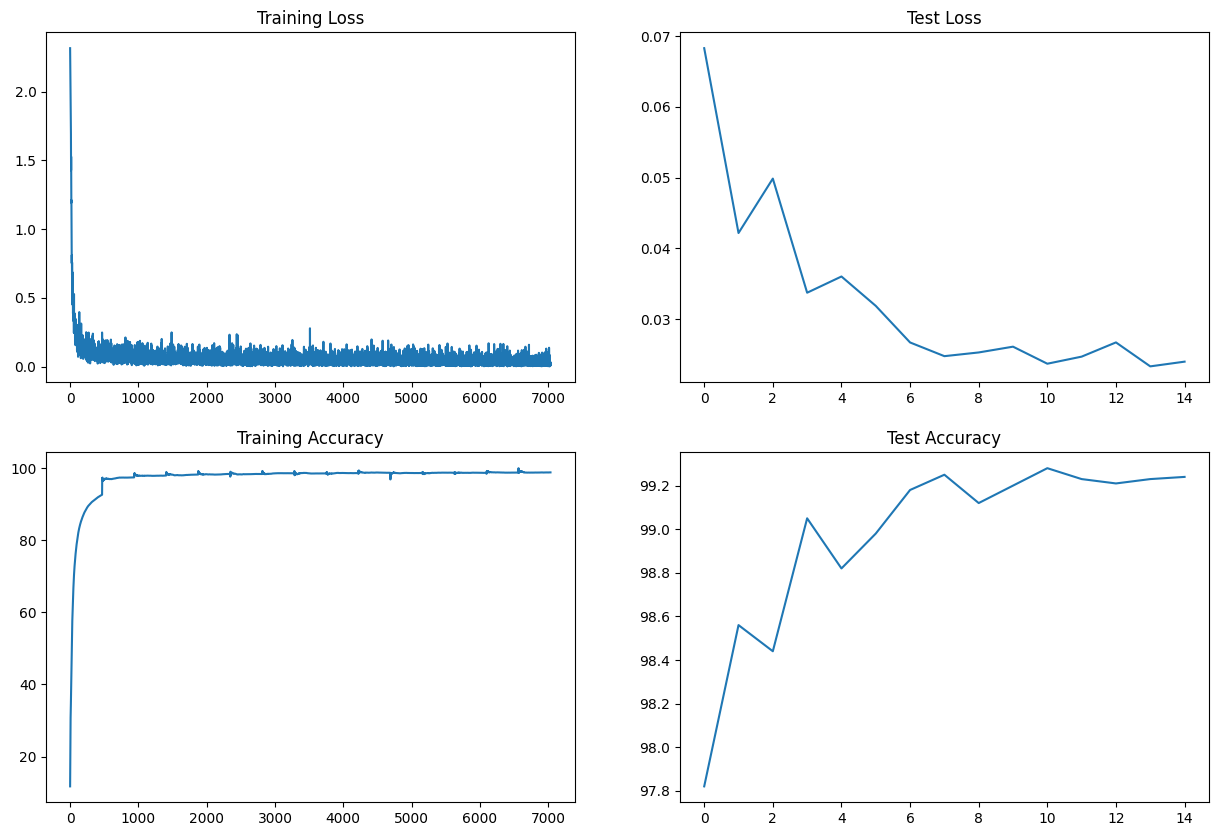

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([i.item() for i in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot([i for i in test_losses])
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")